# Add Sharadar Metadata to LSEG Fundamentals CSV

This notebook enriches your LSEG fundamentals CSV with Sharadar ticker metadata (exchange, category, ADR status, sector, industry, market cap scale, etc.) so that all information is available in a single database table for Pipeline filtering.

## Metadata Columns Added

The following columns will be added with `sharadar_` prefix:

- `sharadar_exchange`: Exchange (NYSE, NASDAQ, NYSEMKT, etc.)
- `sharadar_category`: Stock category (Domestic Common Stock, ADR, ETF, etc.)
- `sharadar_is_adr`: Boolean ADR flag (1=True, 0=False)
- `sharadar_location`: Company location (USA, etc.)
- `sharadar_sector`: Sharadar sector
- `sharadar_industry`: Sharadar industry
- `sharadar_sicsector`: SIC sector
- `sharadar_sicindustry`: SIC industry
- `sharadar_scalemarketcap`: Market cap scale (1-6: Nano to Mega)

## Author
Kamran Sokhanvari / Hidden Point Capital

## 1. Setup and Configuration

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

# Plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 2. Load Sharadar Ticker Metadata

In [2]:
# Import functions from the script (single source of truth with deduplication fix)
import sys
sys.path.insert(0, '/app/examples/lseg_fundamentals')
from add_sharadar_metadata_to_fundamentals import (
    load_sharadar_tickers, 
    add_metadata_to_fundamentals,
    find_newest_csv,
    generate_output_filename
)

print("✓ Imported functions from add_sharadar_metadata_to_fundamentals.py")
print("  - load_sharadar_tickers() - loads and deduplicates Sharadar metadata")
print("  - add_metadata_to_fundamentals() - merges metadata with fundamentals")
print("  - find_newest_csv() - auto-detects newest CSV by date in filename")
print("  - generate_output_filename() - auto-generates output filename")
print("\n⚠️  DEDUPLICATION FIX: Handles multiple entries per ticker (keeps first occurrence)")

✓ Imported functions from add_sharadar_metadata_to_fundamentals.py
  - load_sharadar_tickers() - loads and deduplicates Sharadar metadata
  - add_metadata_to_fundamentals() - merges metadata with fundamentals
  - find_newest_csv() - auto-detects newest CSV by date in filename
  - generate_output_filename() - auto-generates output filename

⚠️  DEDUPLICATION FIX: Handles multiple entries per ticker (keeps first occurrence)


In [3]:
# Configuration
CSV_DIR = '/data/csv/'  # Directory containing LSEG fundamentals CSV files
SHARADAR_BUNDLE = 'sharadar'  # Sharadar bundle name

# Auto-detect newest CSV file by date in filename
print("Auto-detecting newest CSV file...")
INPUT_CSV = find_newest_csv(directory=CSV_DIR)

if INPUT_CSV is None:
    raise FileNotFoundError(f"No CSV files found in {CSV_DIR}")

# Auto-generate output filename
OUTPUT_CSV = generate_output_filename(INPUT_CSV)

print(f"Input CSV: {INPUT_CSV}")
print(f"Output CSV: {OUTPUT_CSV}")
print(f"Sharadar Bundle: {SHARADAR_BUNDLE}")

Auto-detecting newest CSV file...
Found 6 CSV files in /data/csv
  20091231_20251202.csv: 20091231 to 20251202
  20091231_20251209.csv: 20091231 to 20251209

Newest file: 20091231_20251209.csv (20091231 to 20251209)
Input CSV: /data/csv/20091231_20251209.csv
Output CSV: /data/csv/20091231_20251209_with_metadata.csv
Sharadar Bundle: sharadar


In [4]:
# Load Sharadar metadata
sharadar_metadata = load_sharadar_tickers(SHARADAR_BUNDLE)

print(f"\nMetadata shape: {sharadar_metadata.shape}")
print(f"\nColumns: {list(sharadar_metadata.columns)}")
print(f"\nFirst 5 rows:")
sharadar_metadata.head()

Loading Sharadar tickers metadata...
Loaded 60431 tickers
After deduplication: 30899 unique tickers

Metadata shape: (30899, 10)

Columns: ['Symbol', 'exchange', 'category', 'location', 'sector', 'industry', 'sicsector', 'sicindustry', 'scalemarketcap', 'is_adr']

First 5 rows:


,Symbol,exchange,category,location,sector,industry,sicsector,sicindustry,scalemarketcap,is_adr
None,,,,,,,,,,
0,WSGE,NASDAQ,ETF,Pennsylvania; U.S.A,None,None,None,None,None,0
1,KDVD,NYSEARCA,ETF,New York; U.S.A,None,None,None,None,None,0
2,GTOP,NASDAQ,ETF,New York; U.S.A,None,None,None,None,None,0
3,BEDY,NASDAQ,ETF,New York; U.S.A,None,None,None,None,None,0
4,DVGR,NASDAQ,ETF,Pennsylvania; U.S.A,None,None,None,None,None,0


## 3. Metadata Summary Statistics

EXCHANGE DISTRIBUTION
exchange
NASDAQ      15659
NYSE         8493
NYSEARCA     3787
NYSEMKT      1500
BATS         1448
OTC             6
INDEX           5
Name: count, dtype: int64


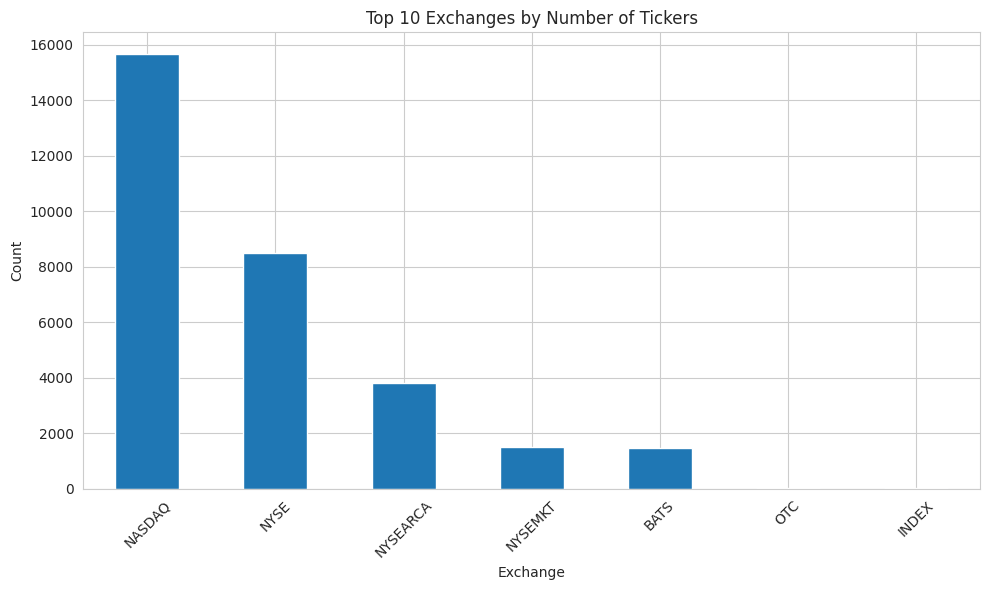

In [5]:
# Exchange distribution
print("=" * 80)
print("EXCHANGE DISTRIBUTION")
print("=" * 80)
print(sharadar_metadata['exchange'].value_counts())

# Plot
plt.figure(figsize=(10, 6))
sharadar_metadata['exchange'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Exchanges by Number of Tickers')
plt.xlabel('Exchange')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

CATEGORY DISTRIBUTION
category
Domestic Common Stock                    13397
ETF                                       6609
Domestic Common Stock Primary Class       2037
ADR Common Stock                          1818
Domestic Common Stock Warrant             1478
Domestic Common Stock Secondary Class     1190
Domestic Preferred Stock                  1117
CEF                                       1068
ETD                                        480
ETN                                        412
Canadian Common Stock                      368
ADR Common Stock Primary Class             258
ADR Common Stock Warrant                   226
ADR Common Stock Secondary Class           152
ADR Preferred Stock                         90
CEF Preferred                               69
CEF Warrant                                 52
UNIT                                        24
ETMF                                        18
Canadian Common Stock Primary Class         15
Canadian Common Stock Warrant

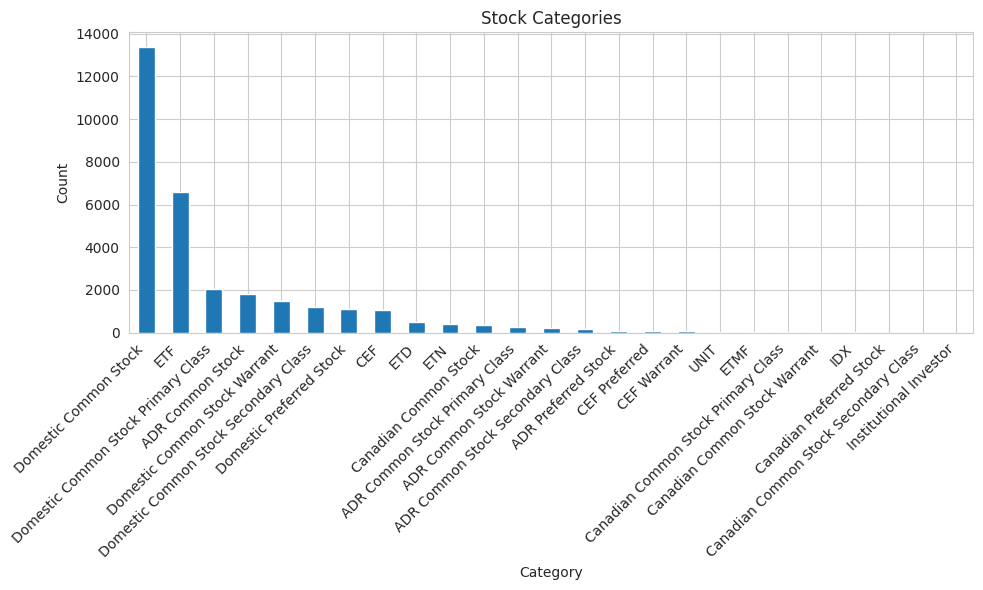

In [6]:
# Category distribution
print("=" * 80)
print("CATEGORY DISTRIBUTION")
print("=" * 80)
print(sharadar_metadata['category'].value_counts())

# Plot
plt.figure(figsize=(10, 6))
sharadar_metadata['category'].value_counts().plot(kind='bar')
plt.title('Stock Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

ADR DISTRIBUTION
Non-ADRs: 28,355
ADRs: 2,544


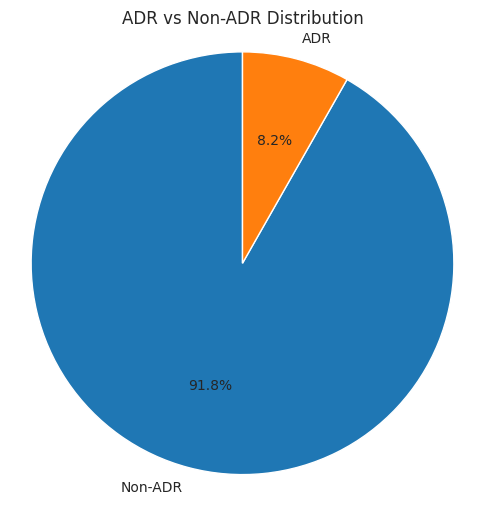

In [7]:
# ADR distribution
print("=" * 80)
print("ADR DISTRIBUTION")
print("=" * 80)
adr_counts = sharadar_metadata['is_adr'].value_counts()
print(f"Non-ADRs: {adr_counts.get(0, 0):,}")
print(f"ADRs: {adr_counts.get(1, 0):,}")

# Plot
plt.figure(figsize=(6, 6))
labels = ['Non-ADR', 'ADR']
sizes = [adr_counts.get(0, 0), adr_counts.get(1, 0)]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('ADR vs Non-ADR Distribution')
plt.axis('equal')
plt.show()

SECTOR DISTRIBUTION
sector
Industrials               4279
Technology                3702
Healthcare                3254
Financial Services        3107
Consumer Cyclical         2056
Communication Services    1241
Real Estate               1099
Basic Materials           1051
Energy                     969
Consumer Defensive         843
Utilities                  424
Name: count, dtype: int64


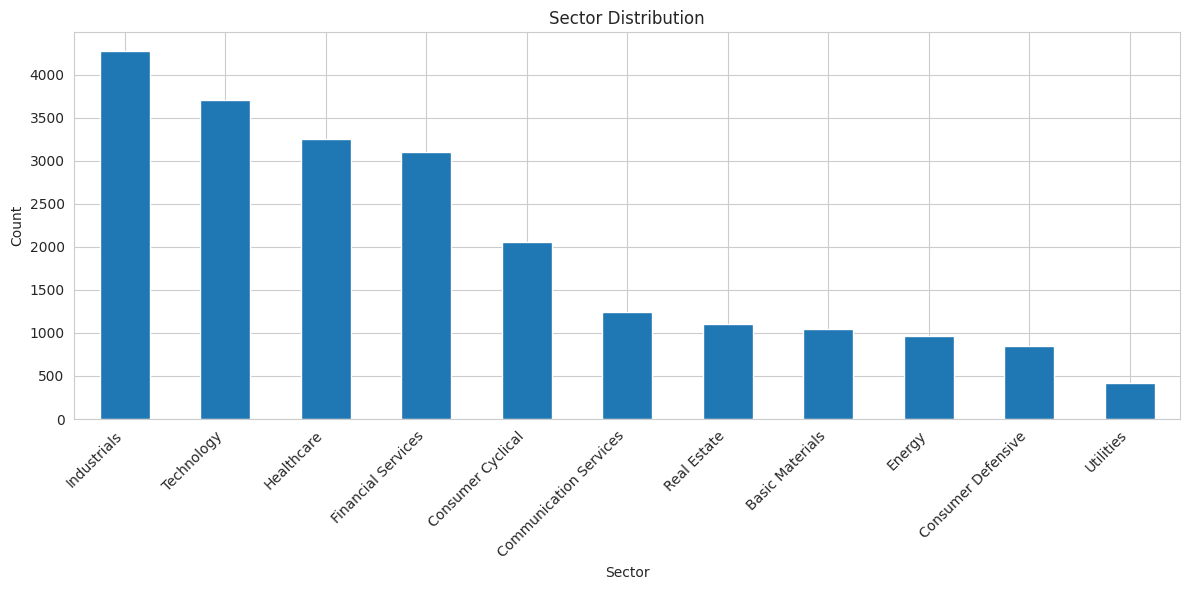

In [8]:
# Sector distribution
if 'sector' in sharadar_metadata.columns:
    print("=" * 80)
    print("SECTOR DISTRIBUTION")
    print("=" * 80)
    print(sharadar_metadata['sector'].value_counts())
    
    # Plot
    plt.figure(figsize=(12, 6))
    sharadar_metadata['sector'].value_counts().plot(kind='bar')
    plt.title('Sector Distribution')
    plt.xlabel('Sector')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

MARKET CAP SCALE DISTRIBUTION
scalemarketcap
1 - Nano     1530
2 - Micro    4492
3 - Small    6140
4 - Mid      3385
5 - Large    1741
6 - Mega       92
Name: count, dtype: int64


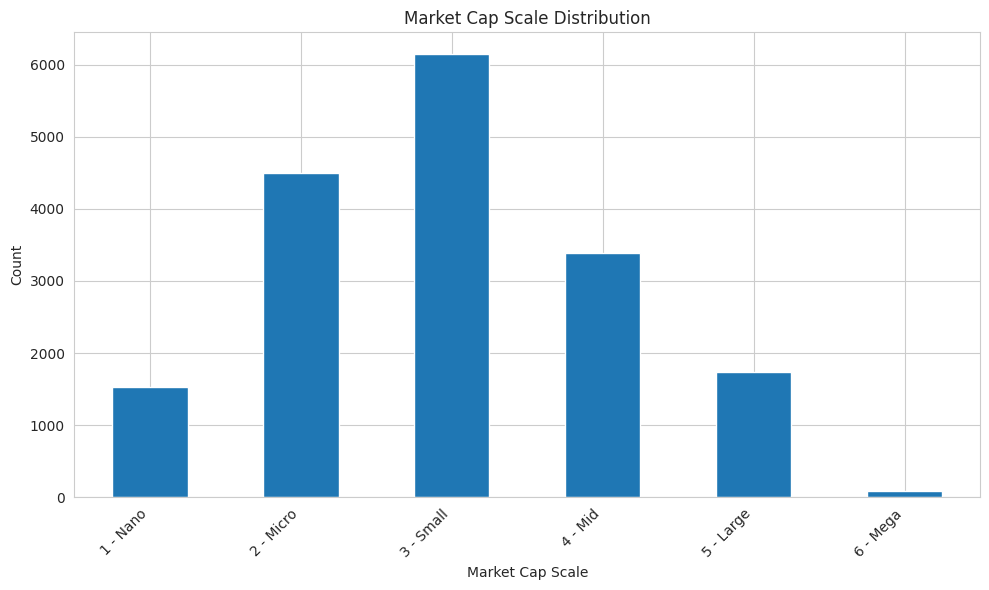

In [9]:
# Market cap scale distribution
if 'scalemarketcap' in sharadar_metadata.columns:
    print("=" * 80)
    print("MARKET CAP SCALE DISTRIBUTION")
    print("=" * 80)
    print(sharadar_metadata['scalemarketcap'].value_counts().sort_index())
    
    # Plot
    plt.figure(figsize=(10, 6))
    sharadar_metadata['scalemarketcap'].value_counts().sort_index().plot(kind='bar')
    plt.title('Market Cap Scale Distribution')
    plt.xlabel('Market Cap Scale')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 4. Load LSEG Fundamentals CSV

In [10]:
# Load LSEG fundamentals
print(f"Loading LSEG fundamentals from: {INPUT_CSV}")
fundamentals = pd.read_csv(INPUT_CSV)

print(f"\nLoaded {len(fundamentals):,} rows, {len(fundamentals.columns)} columns")
print(f"\nColumns: {list(fundamentals.columns)}")

if 'Date' in fundamentals.columns:
    print(f"\nDate range: {fundamentals['Date'].min()} to {fundamentals['Date'].max()}")
    print(f"Unique dates: {fundamentals['Date'].nunique():,}")

if 'Symbol' in fundamentals.columns:
    print(f"Unique symbols: {fundamentals['Symbol'].nunique():,}")

print(f"\nFirst 5 rows:")
fundamentals.head()

Loading LSEG fundamentals from: /data/csv/20091231_20251209.csv

Loaded 9,053,211 rows, 38 columns

Columns: ['Date', 'Symbol', 'Instrument', 'RefPriceClose', 'RefVolume', 'CompanyCommonName', 'EnterpriseValue_DailyTimeSeries_', 'CompanyMarketCap', 'GICSSectorName', 'FOCFExDividends_Discrete', 'InterestExpense_NetofCapitalizedInterest', 'Debt_Total', 'EarningsPerShare_Actual', 'EarningsPerShare_SmartEstimate_prev_Q', 'EarningsPerShare_ActualSurprise', 'EarningsPerShare_SmartEstimate_current_Q', 'LongTermGrowth_Mean', 'PriceTarget_Median', 'CombinedAlphaModelSectorRank', 'CombinedAlphaModelSectorRankChange', 'CombinedAlphaModelRegionRank', 'EarningsQualityRegionRank_Current', 'EnterpriseValueToEBIT_DailyTimeSeriesRatio_', 'EnterpriseValueToEBITDA_DailyTimeSeriesRatio_', 'EnterpriseValueToSales_DailyTimeSeriesRatio_', 'Dividend_Per_Share_SmartEstimate', 'CashCashEquivalents_Total', 'ForwardPEG_DailyTimeSeriesRatio_', 'PriceEarningsToGrowthRatio_SmartEstimate_', 'Recommendation_Median_1_5

,Date,Symbol,Instrument,RefPriceClose,RefVolume,CompanyCommonName,EnterpriseValue_DailyTimeSeries_,CompanyMarketCap,GICSSectorName,FOCFExDividends_Discrete,InterestExpense_NetofCapitalizedInterest,Debt_Total,EarningsPerShare_Actual,EarningsPerShare_SmartEstimate_prev_Q,EarningsPerShare_ActualSurprise,EarningsPerShare_SmartEstimate_current_Q,LongTermGrowth_Mean,PriceTarget_Median,CombinedAlphaModelSectorRank,CombinedAlphaModelSectorRankChange,CombinedAlphaModelRegionRank,EarningsQualityRegionRank_Current,EnterpriseValueToEBIT_DailyTimeSeriesRatio_,EnterpriseValueToEBITDA_DailyTimeSeriesRatio_,EnterpriseValueToSales_DailyTimeSeriesRatio_,Dividend_Per_Share_SmartEstimate,CashCashEquivalents_Total,ForwardPEG_DailyTimeSeriesRatio_,PriceEarningsToGrowthRatio_SmartEstimate_,Recommendation_Median_1_5_,ReturnOnEquity_SmartEstimat,ReturnOnAssets_SmartEstimate,ForwardPriceToCashFlowPerShare_DailyTimeSeriesRatio_,ForwardPriceToSalesPerShare_DailyTimeSeriesRatio_,ForwardEnterpriseValueToOperatingCashFlow_DailyTimeSeriesRatio_,GrossProfitMargin_ActualSurprise,Estpricegrowth_percent,TradeDate
0,2008-10-16,APGT,APGT.PK,0.025000,NaN,Appgate Inc,13205550.0,3.439388e+05,Information Technology,-14000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008-10-16
1,2009-04-22,FIZN,FIZN.PK,20.389298,NaN,First Citizens Bancshares Inc (Tennessee),126856629.0,7.793763e+07,Financials,-753000.0,NaN,110211000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.229962,7.304464,2.417837,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-04-22
2,2009-08-26,EMOR,EMOR.PK,0.040000,NaN,Healixa Inc,NaN,9.061619e+04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-08-26
3,2009-08-26,UCIX,UCIX.PK,121.200000,NaN,Umbra Companies Inc,4970010.0,4.949000e+06,Industrials,8960.0,NaN,5299.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3427.593103,3427.593103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-08-26
4,2009-11-23,HBIA,HBIA.PK,24.500000,NaN,Hills Bancorp,188291469.0,2.160205e+08,Financials,13470000.0,NaN,504874000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.767320,5.379756,1.953353,NaN,114066000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-11-23


## 5. Merge Metadata with Fundamentals

In [11]:
# Merge
enriched = add_metadata_to_fundamentals(fundamentals, sharadar_metadata)

print(f"\n{'='*80}")
print("ENRICHED DATA SUMMARY")
print(f"{'='*80}")
print(f"Original columns: {len(fundamentals.columns)}")
print(f"Enriched columns: {len(enriched.columns)}")
print(f"Metadata columns added: {len([c for c in enriched.columns if c.startswith('sharadar_')])}")


Merging metadata...
Fundamentals shape: (9053211, 38)
Metadata shape: (30899, 10)
Merged shape: (9053211, 47)

Matching statistics:
  Total rows: 9,053,211
  Unique symbols: 4,458
  Rows with metadata: 8,654,064 (95.6%)

ENRICHED DATA SUMMARY
Original columns: 38
Enriched columns: 47
Metadata columns added: 9


## 6. Preview Enriched Data

In [12]:
# Show preview with metadata columns
metadata_cols = [col for col in enriched.columns if col.startswith('sharadar_')]
preview_cols = ['Date', 'Symbol'] + metadata_cols
preview_cols = [col for col in preview_cols if col in enriched.columns]

print("=" * 80)
print("PREVIEW (first 10 rows with metadata):")
print("=" * 80)
print(enriched[preview_cols].head(10).to_string())

PREVIEW (first 10 rows with metadata):
         Date Symbol sharadar_exchange sharadar_category sharadar_location sharadar_sector sharadar_industry sharadar_sicsector sharadar_sicindustry sharadar_scalemarketcap  sharadar_is_adr
0  2008-10-16   APGT                                                                                                                                                                        0
1  2009-04-22   FIZN                                                                                                                                                                        0
2  2009-08-26   EMOR                                                                                                                                                                        0
3  2009-08-26   UCIX                                                                                                                                                                        0
4  2009-11-

In [13]:
# Metadata column summary
print("\n" + "=" * 80)
print("METADATA COLUMN SUMMARY")
print("=" * 80)

for col in sorted(metadata_cols):
    unique_count = enriched[col].nunique()
    null_count = enriched[col].isna().sum()
    empty_count = (enriched[col] == '').sum()
    print(f"{col:40s}: {unique_count:6,} unique, {null_count:8,} nulls, {empty_count:8,} empty")


METADATA COLUMN SUMMARY
sharadar_category                       :     13 unique,        0 nulls,  399,147 empty
sharadar_exchange                       :      7 unique,        0 nulls,  399,147 empty
sharadar_industry                       :    145 unique,        0 nulls, 1,040,617 empty
sharadar_is_adr                         :      2 unique,        0 nulls,        0 empty
sharadar_location                       :     73 unique,        0 nulls,  417,356 empty
sharadar_scalemarketcap                 :      7 unique,        0 nulls, 1,061,820 empty
sharadar_sector                         :     12 unique,        0 nulls, 1,040,617 empty
sharadar_sicindustry                    :    367 unique,        0 nulls, 1,024,781 empty
sharadar_sicsector                      :     10 unique,        0 nulls, 1,024,781 empty


In [14]:
# Sample specific symbols to verify metadata
print("\n" + "=" * 80)
print("SAMPLE SYMBOLS WITH METADATA")
print("=" * 80)

sample_symbols = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
available_samples = [s for s in sample_symbols if s in enriched['Symbol'].values]

if available_samples:
    sample_data = enriched[enriched['Symbol'].isin(available_samples)][preview_cols].drop_duplicates('Symbol')
    print(sample_data.to_string())
else:
    print("None of the sample symbols found in data")


SAMPLE SYMBOLS WITH METADATA
              Date Symbol sharadar_exchange                    sharadar_category  sharadar_location         sharadar_sector               sharadar_industry sharadar_sicsector                                sharadar_sicindustry sharadar_scalemarketcap  sharadar_is_adr
26      2009-12-31   AAPL            NASDAQ                Domestic Common Stock  California; U.S.A              Technology            Consumer Electronics      Manufacturing                                Electronic Computers                6 - Mega                0
101     2009-12-31   AMZN            NASDAQ                Domestic Common Stock  Washington; U.S.A       Consumer Cyclical                 Internet Retail       Retail Trade                  Retail-Catalog & Mail-Order Houses                6 - Mega                0
636     2009-12-31  GOOGL            NASDAQ  Domestic Common Stock Primary Class  California; U.S.A  Communication Services  Internet Content & Information           

## 7. Metadata Distribution in Enriched Data

In [15]:
# Get unique symbol-level data for analysis
unique_symbols = enriched[['Symbol'] + metadata_cols].drop_duplicates('Symbol')

print(f"Analyzing {len(unique_symbols):,} unique symbols")

Analyzing 4,458 unique symbols


EXCHANGE DISTRIBUTION (in enriched data)
sharadar_exchange
NASDAQ      2013
NYSE        1867
             460
NYSEMKT       66
NYSEARCA      43
BATS           6
OTC            3
Name: count, dtype: int64


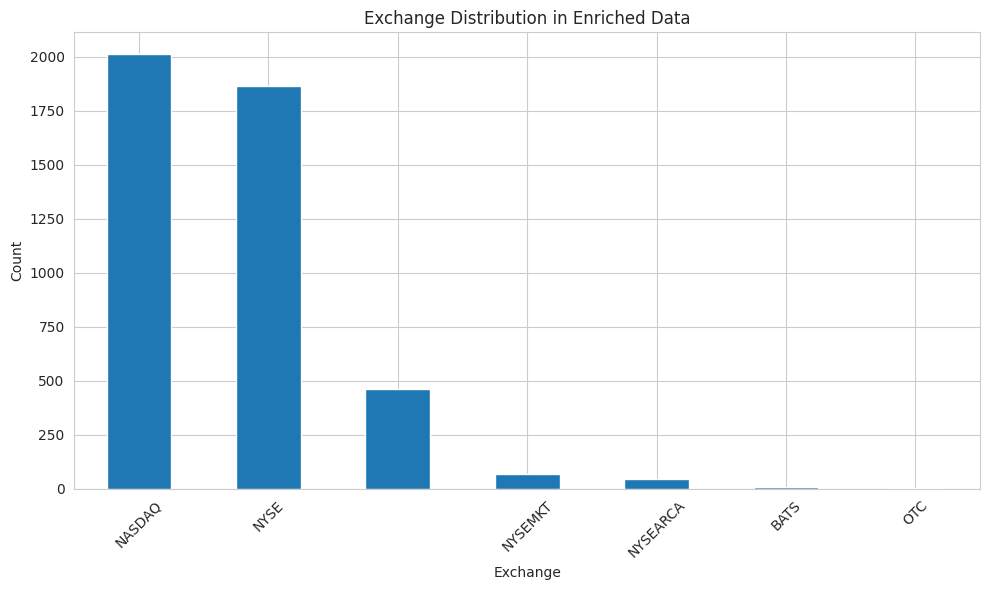

In [16]:
# Exchange distribution in enriched data
if 'sharadar_exchange' in unique_symbols.columns:
    print("=" * 80)
    print("EXCHANGE DISTRIBUTION (in enriched data)")
    print("=" * 80)
    exchange_dist = unique_symbols['sharadar_exchange'].value_counts()
    print(exchange_dist)
    
    # Plot
    plt.figure(figsize=(10, 6))
    exchange_dist.head(10).plot(kind='bar')
    plt.title('Exchange Distribution in Enriched Data')
    plt.xlabel('Exchange')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

CATEGORY DISTRIBUTION (in enriched data)
sharadar_category
Domestic Common Stock                    2731
Domestic Common Stock Primary Class       881
                                          460
CEF                                       258
ETF                                        56
Domestic Common Stock Secondary Class      29
ADR Common Stock                           19
ADR Common Stock Primary Class             12
Domestic Preferred Stock                    4
Canadian Common Stock                       3
UNIT                                        2
ETD                                         2
ADR Common Stock Secondary Class            1
Name: count, dtype: int64


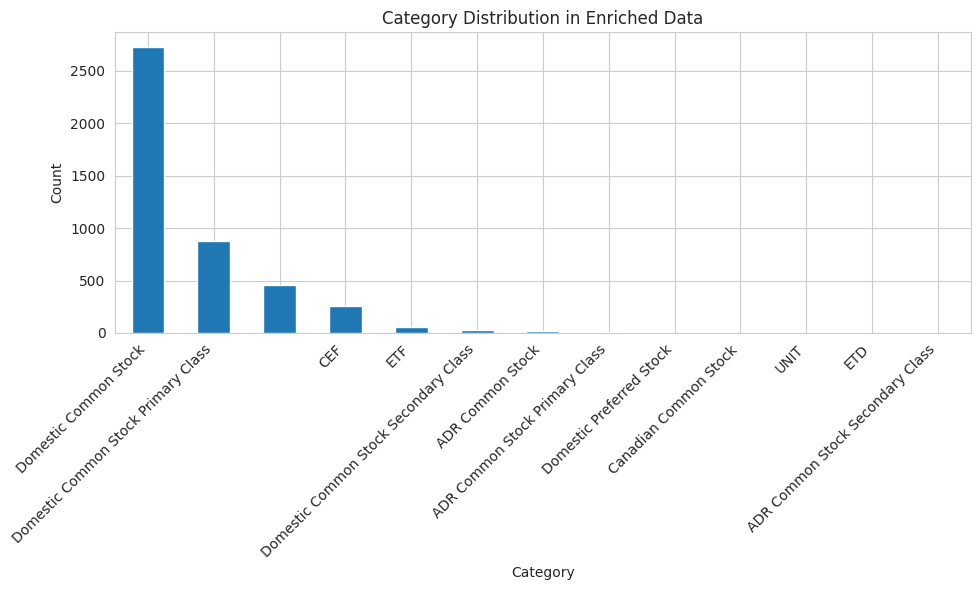

In [17]:
# Category distribution in enriched data
if 'sharadar_category' in unique_symbols.columns:
    print("=" * 80)
    print("CATEGORY DISTRIBUTION (in enriched data)")
    print("=" * 80)
    category_dist = unique_symbols['sharadar_category'].value_counts()
    print(category_dist)
    
    # Plot
    plt.figure(figsize=(10, 6))
    category_dist.plot(kind='bar')
    plt.title('Category Distribution in Enriched Data')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

SECTOR DISTRIBUTION (in enriched data)
sharadar_sector
                          779
Healthcare                682
Industrials               668
Financial Services        543
Technology                518
Consumer Cyclical         357
Real Estate               219
Energy                    172
Basic Materials           164
Consumer Defensive        139
Communication Services    133
Utilities                  84
Name: count, dtype: int64


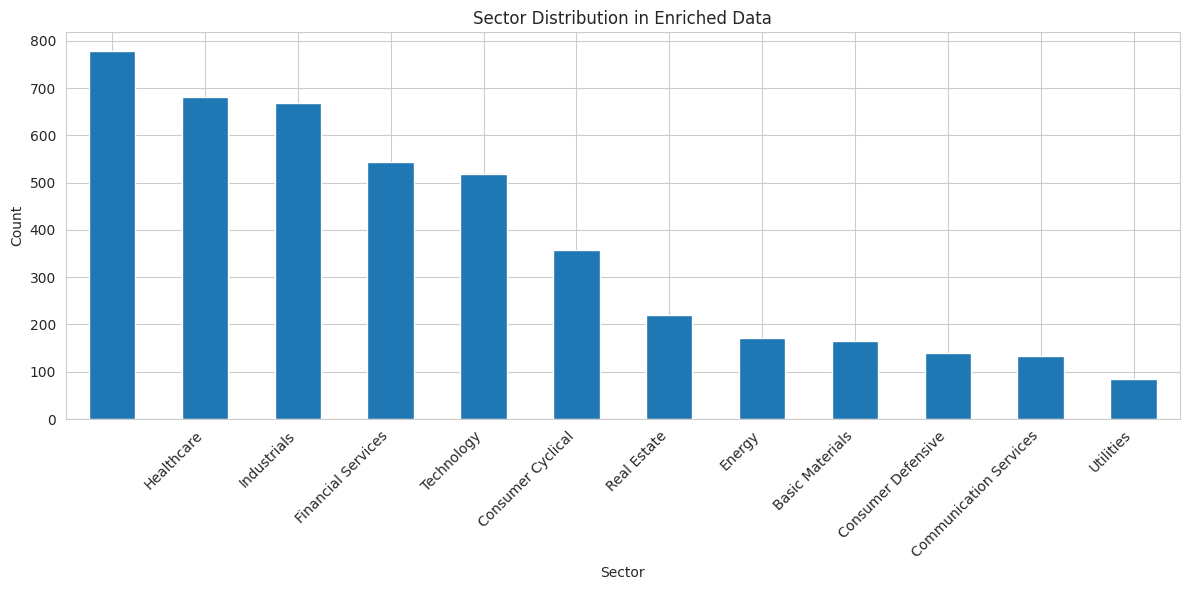

In [18]:
# Sector distribution in enriched data
if 'sharadar_sector' in unique_symbols.columns:
    print("=" * 80)
    print("SECTOR DISTRIBUTION (in enriched data)")
    print("=" * 80)
    sector_dist = unique_symbols['sharadar_sector'].value_counts()
    print(sector_dist)
    
    # Plot
    plt.figure(figsize=(12, 6))
    sector_dist.plot(kind='bar')
    plt.title('Sector Distribution in Enriched Data')
    plt.xlabel('Sector')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## 8. Save Enriched CSV

In [19]:
# Save enriched data
print(f"Saving enriched data to: {OUTPUT_CSV}")
enriched.to_csv(OUTPUT_CSV, index=False)

print(f"\n✓ Saved {len(enriched):,} rows to {OUTPUT_CSV}")

Saving enriched data to: /data/csv/20091231_20251209_with_metadata.csv

✓ Saved 9,053,211 rows to /data/csv/20091231_20251209_with_metadata.csv


## 9. Summary Report

In [20]:
print("\n" + "=" * 80)
print("FINAL SUMMARY")
print("=" * 80)
print(f"Original columns: {len(fundamentals.columns)}")
print(f"Enriched columns: {len(enriched.columns)}")
print(f"Metadata columns added: {len(metadata_cols)}")

print("\nNew metadata columns:")
for col in sorted(metadata_cols):
    print(f"  - {col}")

print("\n" + "=" * 80)
print("NEXT STEPS")
print("=" * 80)
print(f"1. Load the enriched CSV into fundamentals.sqlite:")
print(f"   python examples/lseg_fundamentals/load_csv_fundamentals.py")
print(f"")
print(f"2. Use the metadata columns in your Pipeline strategies:")
print(f"   - Filter by exchange: sharadar_exchange")
print(f"   - Filter by category: sharadar_category")
print(f"   - Exclude ADRs: sharadar_is_adr == 0")
print(f"   - Filter by sector: sharadar_sector")
print(f"   - Filter by market cap scale: sharadar_scalemarketcap")
print(f"")
print(f"3. Example Pipeline filter:")
print(f"   exchange_filter = (CustomFundamentals.sharadar_exchange.latest == 'NYSE')")
print(f"   category_filter = (CustomFundamentals.sharadar_category.latest == 'Domestic Common Stock')")
print(f"   no_adr_filter = (CustomFundamentals.sharadar_is_adr.latest == 0)")
print(f"   universe = exchange_filter & category_filter & no_adr_filter")
print("\n✓ Done!")


FINAL SUMMARY
Original columns: 38
Enriched columns: 47
Metadata columns added: 9

New metadata columns:
  - sharadar_category
  - sharadar_exchange
  - sharadar_industry
  - sharadar_is_adr
  - sharadar_location
  - sharadar_scalemarketcap
  - sharadar_sector
  - sharadar_sicindustry
  - sharadar_sicsector

NEXT STEPS
1. Load the enriched CSV into fundamentals.sqlite:
   python examples/lseg_fundamentals/load_csv_fundamentals.py

2. Use the metadata columns in your Pipeline strategies:
   - Filter by exchange: sharadar_exchange
   - Filter by category: sharadar_category
   - Exclude ADRs: sharadar_is_adr == 0
   - Filter by sector: sharadar_sector
   - Filter by market cap scale: sharadar_scalemarketcap

3. Example Pipeline filter:
   exchange_filter = (CustomFundamentals.sharadar_exchange.latest == 'NYSE')
   category_filter = (CustomFundamentals.sharadar_category.latest == 'Domestic Common Stock')
   no_adr_filter = (CustomFundamentals.sharadar_is_adr.latest == 0)
   universe = exc

## 10. Sample Data for AAPL

View the last 10 rows of enriched data for AAPL to see all columns with metadata.

In [23]:
# Get last 10 rows for AAPL
print("=" * 80)
print("LAST 10 ROWS FOR AAPL (with all columns)")
print("=" * 80)

if 'AAPL' in enriched['Symbol'].values:
    aapl_data = enriched[enriched['Symbol'] == 'AAPL'].tail(10)
    
    print(f"\nShowing last 10 rows of {len(enriched[enriched['Symbol'] == 'AAPL'])} total rows for AAPL")
    print(f"Date range: {aapl_data['Date'].min()} to {aapl_data['Date'].max()}")
    print(f"\nColumns: {len(aapl_data.columns)}")
    print("\n" + "=" * 80)
    
    # Display with pandas settings for full visibility
    with pd.option_context('display.max_columns', None,
                          'display.max_rows', None,
                          'display.width', None,
                          'display.max_colwidth', 50):
        print(aapl_data)
    
    print("\n" + "=" * 80)
    print("AAPL METADATA SUMMARY")
    print("=" * 80)
    
    # Show just the metadata columns for clarity
    metadata_cols_display = [col for col in aapl_data.columns if col.startswith('sharadar_')]
    if metadata_cols_display:
        aapl_metadata = aapl_data[['Date', 'Symbol'] + metadata_cols_display].tail(1)
        print("\nSharadar Metadata for AAPL:")
        for col in metadata_cols_display:
            value = aapl_metadata[col].iloc[0]
            print(f"  {col:40s}: {value}")
else:
    print("AAPL not found in enriched data")

LAST 10 ROWS FOR AAPL (with all columns)

Showing last 10 rows of 4010 total rows for AAPL
Date range: 2025-11-25 to 2025-12-09

Columns: 47

               Date Symbol Instrument  RefPriceClose   RefVolume  \
9023510  2025-11-25   AAPL    AAPL.OQ         276.97  15797658.0   
9026516  2025-11-26   AAPL    AAPL.OQ         277.55  13747581.0   
9029506  2025-11-28   AAPL    AAPL.OQ         278.85   7704363.0   
9032483  2025-12-01   AAPL    AAPL.OQ         283.10  16489958.0   
9035474  2025-12-02   AAPL    AAPL.OQ         286.19  17616578.0   
9038455  2025-12-03   AAPL    AAPL.OQ         284.15  15041348.0   
9041407  2025-12-04   AAPL    AAPL.OQ         280.70  18470621.0   
9044359  2025-12-05   AAPL    AAPL.OQ         278.78  13788143.0   
9047312  2025-12-08   AAPL    AAPL.OQ         277.89  13039359.0   
9050266  2025-12-09   AAPL    AAPL.OQ         277.18  12336953.0   

        CompanyCommonName  EnterpriseValue_DailyTimeSeries_  CompanyMarketCap  \
9023510         Apple Inc   